## Melanoma Detection

## Problem statement
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
#importing the libraries
import numpy as np
import pandas as pd
import pathlib
import os
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img

In [ ]:

!nvidia-smi

Fri Aug 11 01:37:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#mounting the file from the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#unzipping the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

In [ ]:
# Assigning the train data to the malanoma_train variable
melanoma_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")

In [ ]:
# Assigning the test data to the malanoma_test variable
melanoma_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
# Counting the number of images in Train and Test dataset and assigning to the variables
image_train_count = len(list(melanoma_train.glob('*/*.jpg')))
print("image_train_count = ",image_train_count)

image_test_count = len(list(melanoma_test.glob('*/*.jpg')))
print("image_train_count = ",image_test_count)

image_train_count =  2239
image_train_count =  118


### **Data Visualization**

Found 2239 files belonging to 9 classes.


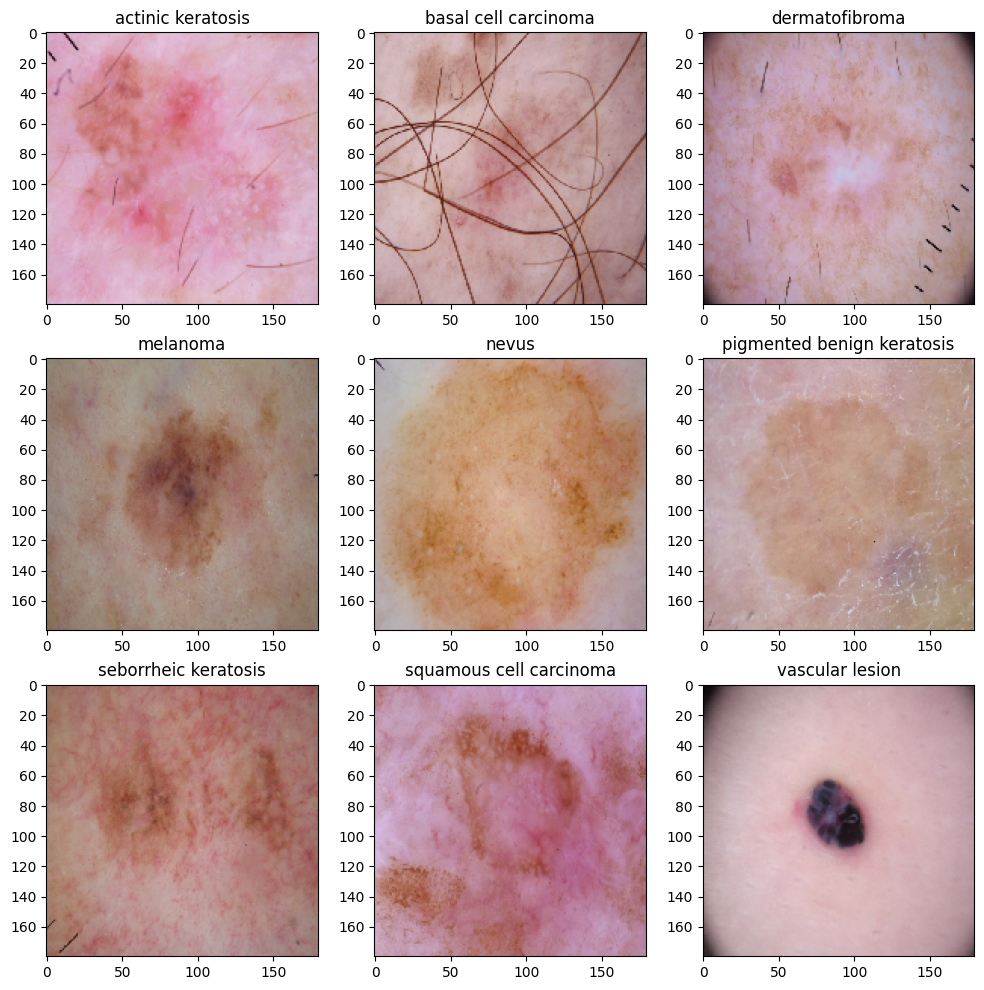

In [ ]:
#Visualizing one instance of all the classes present in the dataset.

#the function image_dataset_from_directoryrom_dictionary() will produce a tf.data.Dataset that provides sets of image batches originating from the subdirectories.
#If label_mode is set to "categorical", the labels will be represented as a float32 tensor with a shape of (batch_size, num_classes), which corresponds to a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(melanoma_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#assigning all the classes of Skin Cancer to the class_names
class_names = image_dataset.class_names

#creating the dictionary that stores the path of image as per the class
path_dict = {}

for c in class_names:
    path_dict[c] = list(map(lambda x:str(melanoma_train)+'/'+c+'/'+x,os.listdir(str(melanoma_train)+'/'+c)))

#Visualizing images
plt.figure(figsize=(12,12))
index_count = 0

for c in class_names:
    path_list = path_dict[c][:1]
    index_count += 1
    plt.subplot(3,3,index_count)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)


**Visualize distribution of classes in the training dataset.**

In [ ]:
def class_dist_count(directory):
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #names of the classes in the list of
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'Number of Images'])

In [ ]:
data_frame = class_dist_count(melanoma_train)
data_frame

,Class,Number of Images
0,actinic keratosis,114
1,squamous cell carcinoma,181
2,seborrheic keratosis,77
3,melanoma,438
4,vascular lesion,139
5,basal cell carcinoma,376
6,dermatofibroma,95
7,pigmented benign keratosis,462
8,nevus,357


<Axes: xlabel='Number of Images', ylabel='Class'>

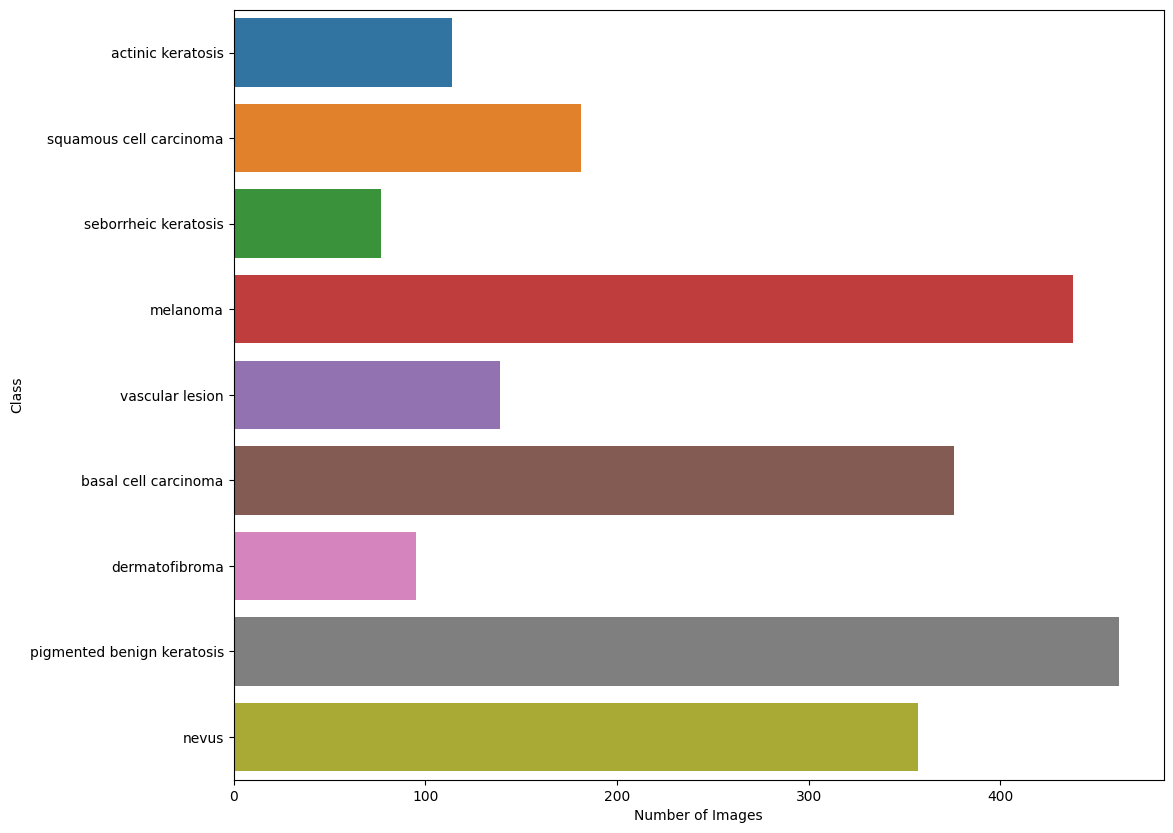

In [ ]:
#Visualizing the Number of image in each class.
import seaborn as sns
sns.color_palette("tab10")
plt.figure(figsize=(12, 10))
sns.barplot(x="Number of Images", y="Class", data=data_frame,label="Class")

In order to address the issue of class imbalance, the Python package Augmentor (https://augmentor.readthedocs.io/en/master/) can be used to generate additional samples across all classes, ensuring that none of the classes have an insufficient number of samples.

In [ ]:
#installing the Augmentor
!pip install Augmentor

In [ ]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
training_dataset_path="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(training_dataset_path + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)
    #By adding 500 samples per class, it can be ensured that none of the classes have a sparse representation in the dataset.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A44CC07FB20>: 100%|██████████| 500/500 [00:19<00:00, 26.22 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A44B8E16B90>: 100%|██████████| 500/500 [00:22<00:00, 22.16 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A44CC07FB20>: 100%|██████████| 500/500 [00:20<00:00, 24.49 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A44CC0DD900>: 100%|██████████| 500/500 [01:15<00:00,  6.61 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A455CE471F0>: 100%|██████████| 500/500 [01:06<00:00,  7.54 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A455CFFE680>: 100%|██████████| 500/500 [00:15<00:00, 31.87 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A44CC0DE050>: 100%|██████████| 500/500 [00:37<00:00, 13.51 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A455CFFD150>: 100%|██████████| 500/500 [00:17<00:00, 28.01 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A44B9788B50>: 100%|██████████| 500/500 [00:16<00:00, 30.63 Samples/s]


In [ ]:
#Counting the total number of image generated by Augmentor.
image_train_count = len(list(melanoma_train.glob('*/output/*.jpg')))
print("image_train_count = ",image_train_count)

image_train_count =  4500


**Model Building**

In [ ]:
# train dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(melanoma_train, batch_size=32, image_size=(180,180), label_mode='categorical',
                                                               seed=48,subset="training",
                                                               validation_split=0.2)

# If label_mode is set to "categorical", the labels are a float32 tensor with a shape of (batch_size, num_classes),
# which signifies that the labels are using a one-hot encoding method to represent the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
# validation dataset
val_dataset =tf.keras.preprocessing.image_dataset_from_directory(melanoma_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=48,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#CNN Model Architecture

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer for the data
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer for the data
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer for the data
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

In [ ]:
#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#The softmax function is utilized as an activation function to convert numerical values or logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

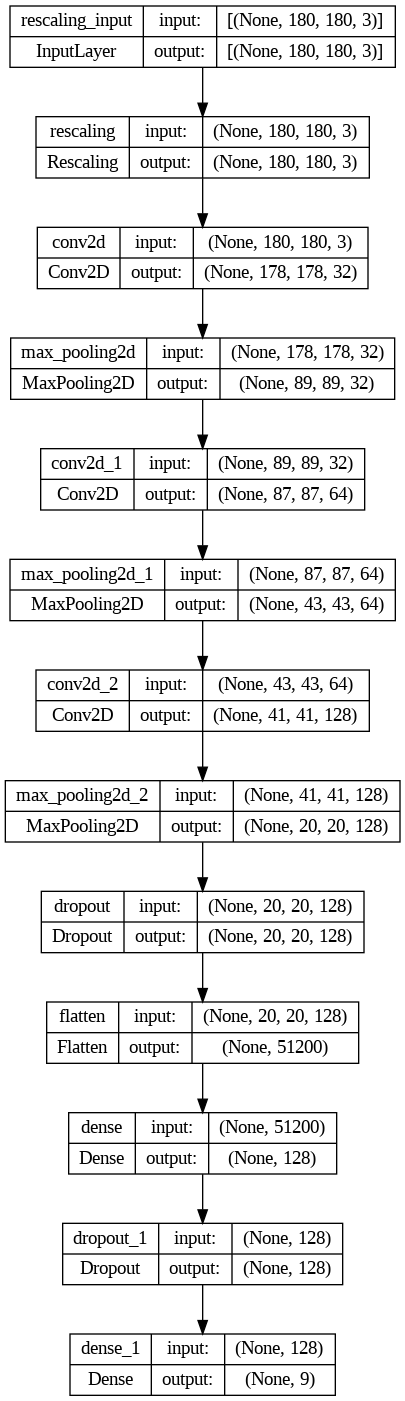

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Compile the Model

#The Adam optimization algorithm is a type of stochastic gradient descent that employs adaptive estimation of the first and second moments to update the parameters of a neural network.
#This enables the algorithm to optimize the network more efficiently by adjusting the learning rate of each weight parameter based on the magnitude of its gradients.
#categorical_crossentropy: This loss function is utilized for training a multi-class classification model with two or more output labels..

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#The ModelCheckpoint callback function is utilized in combination with the model.fit() function during training to periodically save a model or its weights in a checkpoint file.
#This enables the model to be loaded later, allowing training to continue from the previously saved state..
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
# Training the model
epochs = 20
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 2.0979 - accuracy: 0.1984
Epoch 1: val_accuracy improved from -inf to 0.32517, saving model to model.h5
169/169 [==============================] - 61s 90ms/step - loss: 2.0979 - accuracy: 0.1984 - val_loss: 1.7863 - val_accuracy: 0.3252
Epoch 2/20
168/169 [============================>.] - ETA: 0s - loss: 1.6394 - accuracy: 0.3838
Epoch 2: val_accuracy improved from 0.32517 to 0.43133, saving model to model.h5
169/169 [==============================] - 9s 55ms/step - loss: 1.6384 - accuracy: 0.3843 - val_loss: 1.4630 - val_accuracy: 0.4313
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.4270 - accuracy: 0.4483
Epoch 3: val_accuracy improved from 0.43133 to 0.50928, saving model to model.h5
169/169 [==============================] - 9s 54ms/step - loss: 1.4270 - accuracy: 0.4483 - val_loss: 1.2903 - val_accuracy: 0.5093
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 1.341

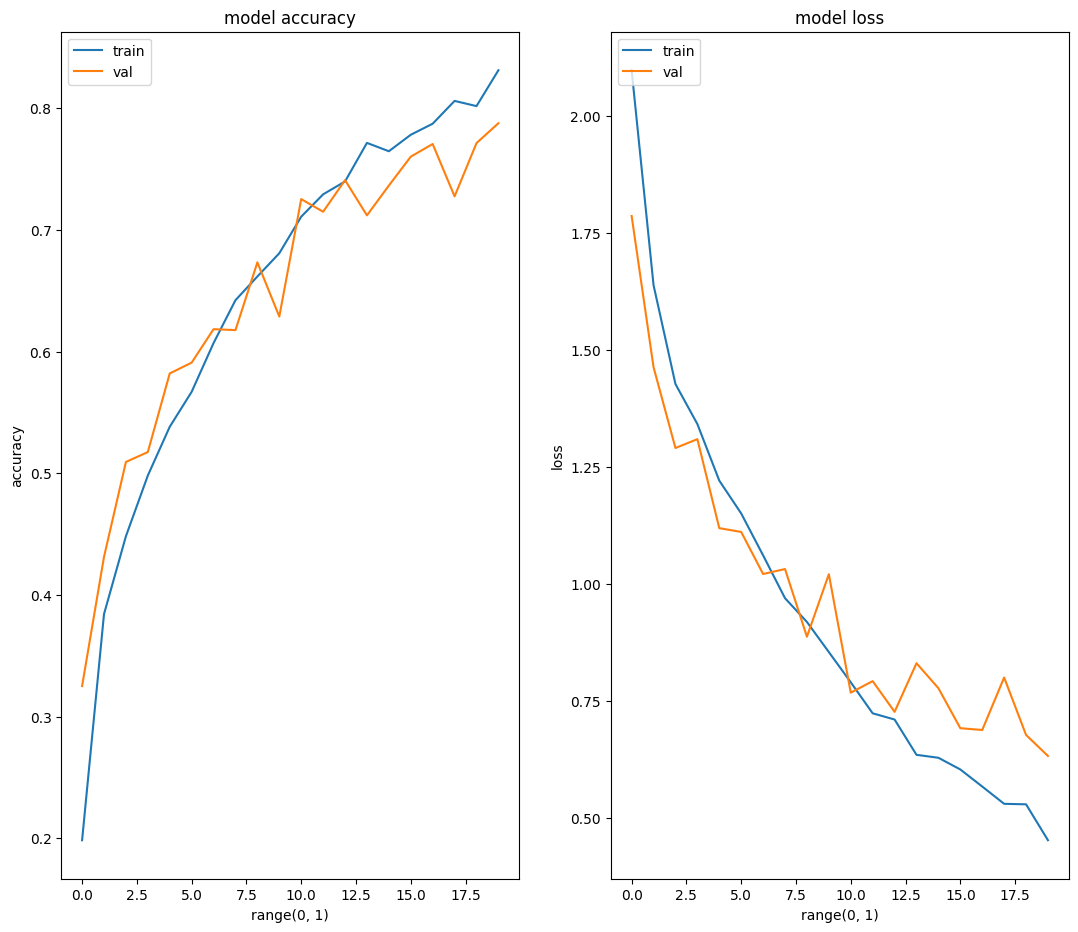

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(13, 11))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Predicting for the test data

1/1 [==============================] - 0s 284ms/step
Actual Class basal cell carcinoma
Predictive Class melanoma


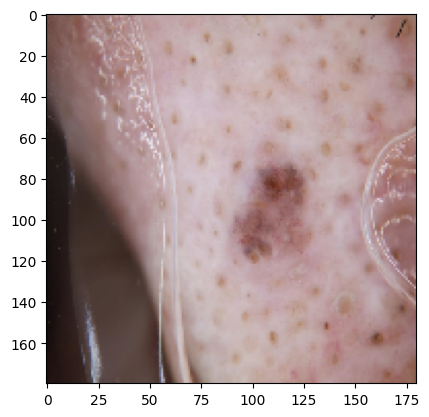

In [ ]:
from glob import glob
Test_image_path = os.path.join(melanoma_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

In [ ]:
# Save the model in HDF5 format
model.save('skin_cancer_model.h5')



In [ ]:
"""import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os
from glob import glob

# ... (your existing code for model training and evaluation)

# Save the trained model using TensorFlow's save() function
model.save("melanoma_model.h5")

# Now, you can save the class_names and other necessary information in a dictionary
model_info = {
    "class_names": class_names,
    # Add any other relevant information you might need when loading the model
}

# Save the model_info dictionary to a pickle file
with open("model_info.pkl", "wb") as f:
    pickle.dump(model_info, f)

# Later, when you want to load the model and its information:

# Load the model
loaded_model = tf.keras.models.load_model("melanoma_model.h5")

# Load the model_info dictionary from the pickle file
with open("model_info.pkl", "rb") as f:
    loaded_model_info = pickle.load(f)

# Extract any necessary information from the loaded_model_info
loaded_class_names = loaded_model_info["class_names"]

# Now you can use the loaded_model to make predictions and the loaded_class_names to interpret the results.
"""

'import pickle\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras import layers\nfrom tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping\nimport matplotlib.pyplot as plt\nimport os\nfrom glob import glob\n\n# ... (your existing code for model training and evaluation)\n\n# Save the trained model using TensorFlow\'s save() function\nmodel.save("melanoma_model.h5")\n\n# Now, you can save the class_names and other necessary information in a dictionary\nmodel_info = {\n    "class_names": class_names,\n    # Add any other relevant information you might need when loading the model\n}\n\n# Save the model_info dictionary to a pickle file\nwith open("model_info.pkl", "wb") as f:\n    pickle.dump(model_info, f)\n\n# Later, when you want to load the model and its information:\n\n# Load the model\nloaded_model = tf.keras.models.load_model("melanoma_model.h5")\n\n# Load the model_info dictionary from the pickle file\nwith open("model_info.pk

## Thank you